# Compare polynomial fitting with neural network regressor

## In this example, a noisy cosine function is fitted by 3 polynomes of different orders, and 3 neural networks with different layers sizes.

***

### Import usefull libraries.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

### The polynomial fit is performed using the scikit modules. 

In [2]:
import tensorflow
print(tensorflow.__version__)

2.0.0


In [3]:
# Import stuff to perform the polynomial fit
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
# Import tool to compute rms
from sklearn.metrics import mean_squared_error
# Import the TMNI. If not installed, install it
try:
    import ai4neb
except:
    !pip install -U git+https://github.com/morisset/AI4neb.git
    import ai4neb

### Define the function we want to interpolate.

In [4]:
def true_fun(x):
    return np.cos(1.5 * np.pi * x)

### Define some parameters. The X_train and y_train sets are used to determine the polynome coefficients and also to train the neural networks. 

In [5]:
# A random seed to reproduce the results
np.random.seed(0)

# The number of points used to fit the function
n_samples = 30

# Noise to be added to the points used to fit the function
noise = 0.1

# The training set: n_samples X points, with the noisy correspoing y  
X = np.sort(np.random.rand(n_samples))
y = true_fun(X) + np.random.randn(n_samples) * noise
X_train = X
y_train_true = y

# The set of points to verify the fit quality
X_test = np.linspace(0, 1, 100)
y_test_true = true_fun(X_test)

### The pipeline object is defined to fit the X_train - y_train data sets. The order of the polynome is set to 2.

In [6]:
degree = 2
polynomial_features = PolynomialFeatures(degree=degree,
                                         include_bias=False)
model = LinearRegression()
X_TRANSF = polynomial_features.fit_transform(X_train[:, np.newaxis])
model.fit(X_TRANSF, y_train_true)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

### The RMS of the fit computed on the dataused to determine the coefficients is computed.

In [7]:
y_train = model.predict(X_TRANSF)
rms_train = np.sqrt(mean_squared_error(y_train,y_train_true))

### The RMS of the fit computed on the test sample (100 points between 0 and 1) is computed.

In [8]:
y_test = model.predict(polynomial_features.fit_transform(X_test[:, np.newaxis]))
rms_test = np.sqrt(mean_squared_error(y_test,y_test_true))

In [9]:
poly = lambda x: model.intercept_ + model.coef_[0] * x + model.coef_[1] * x**2

### A plot is done to show the original function, the training sample and the polynomial fit.

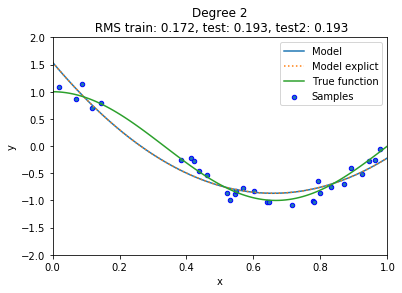

In [11]:
f, ax = plt.subplots()
ax.plot(X_test, y_test, label="Model")
ax.plot(X_test, poly(X_test), label="Model explict", ls=':')
ax.plot(X_test, y_test_true, label="True function")
ax.scatter(X, y, edgecolor='b', s=20, label="Samples")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_xlim((0, 1))
ax.set_ylim((-2, 2))
ax.legend(loc="best")
ax.set_title("Degree {}\n RMS train: {:.3f}, test: {:.3f}, test2: {:.3f}".format(degree,
             rms_train, rms_test, rms_test));

### A Neural Network is used on the same data points. 

### It is trained on the training sets. Hyper-parameters can be changed.

In [12]:
RM = ai4neb.manage_RM(RM_type='SK_ANN', X_train=X_train, y_train=y_train_true, scaling=False,
                  verbose=True, random_seed=10)
RM.init_RM(hidden_layer_sizes=(2,), 
           tol=1e-6, max_iter=10000, 
#           epochs=100,
           activation='tanh',
           solver='adam')
RM.train_RM()

Instantiation. V 0.17
Training set size = 30, Test set size = 0
Training set size = 30, Test set size = 0
Regression Model SK_ANN
Training 1 inputs for 1 outputs with 30 data
RM trained, with 7497 iterations. Score = 0.968
MLPRegressor(activation='tanh', alpha=0.0001, batch_size='auto', beta_1=0.9,
             beta_2=0.999, early_stopping=False, epsilon=1e-08,
             hidden_layer_sizes=(2,), learning_rate='constant',
             learning_rate_init=0.001, max_fun=15000, max_iter=10000,
             momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
             power_t=0.5, random_state=10, shuffle=True, solver='adam',
             tol=1e-06, validation_fraction=0.1, verbose=False,
             warm_start=False)
Training time 1.5 s.


### Predictions of the ANN are performed on the training and test sets.

In [13]:
RM.set_test(X_train)
RM.predict()
y_train = RM.pred
rms_train = np.sqrt(mean_squared_error(y_train, y_train_true))
RM.set_test(X_test)
RM.predict()
y_test = RM.pred
rms_test = np.sqrt(mean_squared_error(y_test, y_test_true))

Predicting from 1 inputs to 1 outputs using 30 data in 0.00 secs.
Predicting from 1 inputs to 1 outputs using 100 data in 0.00 secs.


In [14]:
rm = RM.RMs[0]
print(rm.coefs_)
print(rm.intercepts_)
# coefs_[i_layer][i_previous cell][i_cell]
# intercepts_[i_layer][i_cell]

[array([[-4.12860829,  1.96768195]]), array([[1.89119615],
       [1.93065577]])]
[array([ 1.69619665, -1.5975606 ]), array([0.99706842])]


In [20]:
activation = lambda x: np.tanh(x)
cel_0 = lambda x: activation(x * rm.coefs_[0][0][0] + rm.intercepts_[0][0])
cel_1 = lambda x: activation(x * rm.coefs_[0][0][1] + rm.intercepts_[0][1])
output = lambda x: cel_0(x) * rm.coefs_[1][0][0] + cel_1(x) * rm.coefs_[1][1][0] + rm.intercepts_[1][0]

### A plot is done to show the original function, the training sample and the polynomial fit.

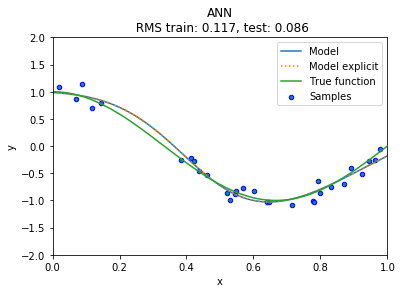

In [19]:
f, ax = plt.subplots()
ax.plot(X_test, y_test, label="Model")
ax.plot(X_test, output(X_test), label="Model explicit", ls=':')
ax.plot(X_test, y_test_true, label="True function")

ax.scatter(X, y, edgecolor='b', s=20, label="Samples")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_xlim((0, 1))
ax.set_ylim((-2, 2))
ax.legend(loc="best")
ax.set_title("ANN\n RMS train: {:.3f}, test: {:.3f}".format(
             rms_train, rms_test));

### A comparison is made between 3 polynomial fits and 3 ANN computations.

Instantiation. V 0.17
Training set size = 30, Test set size = 0
Train data scaled. 
Test data scaled. 
Training set size = 30, Test set size = 0
Training set size = 30, Test set size = 0
Regression Model SK_ANN
Training 1 inputs for 1 outputs with 30 data
RM trained, with 5405 iterations. Score = 0.959
MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
             beta_2=0.999, early_stopping=False, epsilon=1e-08,
             hidden_layer_sizes=(3,), learning_rate='constant',
             learning_rate_init=0.001, max_fun=15000, max_iter=10000,
             momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
             power_t=0.5, random_state=10, shuffle=True, solver='adam',
             tol=1e-06, validation_fraction=0.1, verbose=False,
             warm_start=False)
Training time 1.3 s.
Test data scaled. 
Training set size = 30, Test set size = 30
Predicting from 1 inputs to 1 outputs using 30 data in 0.00 secs.
Test data scaled. 
Training set 

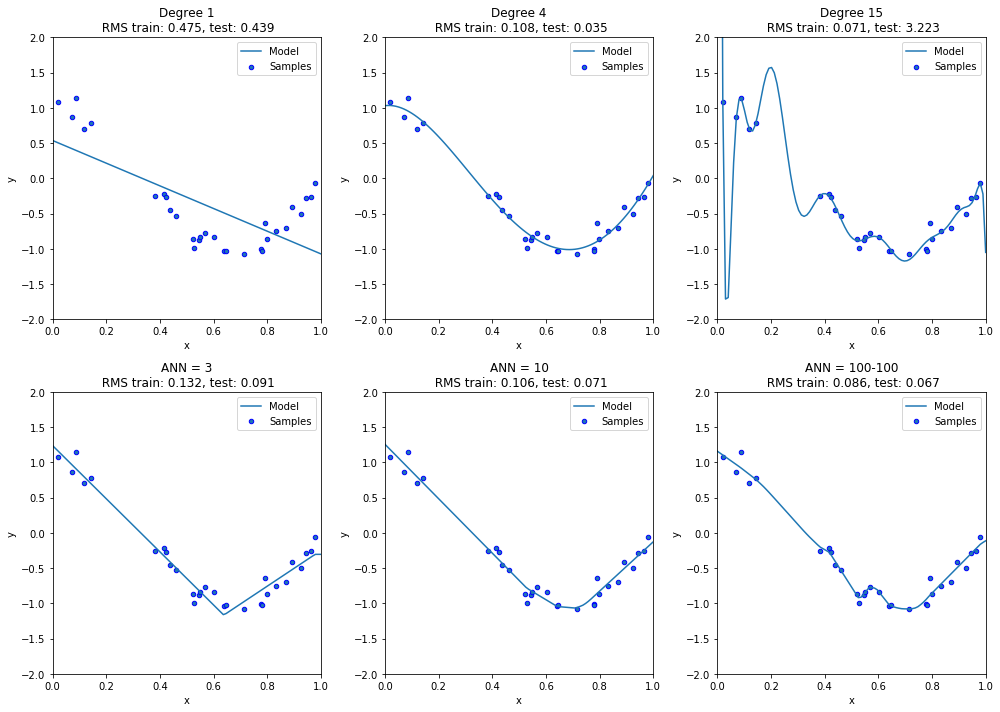

In [13]:
f, axes = plt.subplots(2, 3, figsize=(14, 10))

degrees = [1, 4, 15]
for i in range(len(degrees)):
    ax = axes[0,i]

    polynomial_features = PolynomialFeatures(degree=degrees[i],
                                             include_bias=False)
    linear_regression = LinearRegression()
    pipeline = Pipeline([("polynomial_features", polynomial_features),
                         ("linear_regression", linear_regression)])
    pipeline.fit(X_train[:, np.newaxis], y_train_true)
    y_train = pipeline.predict(X_train[:, np.newaxis])
    y_test = pipeline.predict(X_test[:, np.newaxis])
    rms_train = np.sqrt(mean_squared_error(y_train,y_train_true))
    rms_test = np.sqrt(mean_squared_error(y_test,y_test_true))
    ax.plot(X_test, y_test, label="Model")
    #ax.plot(X_test, y_test_true, label="True function")
    ax.scatter(X, y, edgecolor='b', s=20, label="Samples")
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_xlim((0, 1))
    ax.set_ylim((-2, 2))
    ax.legend(loc="best")
    ax.set_title("Degree {}\n RMS train: {:.3f}, test: {:.3f}".format( degrees[i],
                 rms_train, rms_test))

hidden_layer_sizes_set = ( (3,), (10,), (100, 100))
hidden_layer_sizes_strs = ('3', '10', '100-100')
for i in range(len(hidden_layer_sizes_set)):
    scaleit=True
    RM = ai4neb.manage_RM(RM_type='SK_ANN', X_train=X_train, y_train=y_train_true, scaling=scaleit,
                      verbose=True, random_seed=10)
    RM.init_RM(hidden_layer_sizes=hidden_layer_sizes_set[i], 
               tol=1e-6, max_iter=10000, 
#               epochs = 10000,
               activation='relu',
               solver='adam')
    RM.train_RM()
    RM.set_test(X_train)
    RM.predict()
    y_train = RM.pred
    RM.set_test(X_test)
    RM.predict()
    y_test = RM.pred
    rms_train = np.sqrt(mean_squared_error(y_train, y_train_true))
    rms_test = np.sqrt(mean_squared_error(y_test, y_test_true))
    ax = axes[1,i]
    ax.plot(X_test, y_test, label="Model")
    #ax.plot(X_test, y_test_true, label="True function")
    ax.scatter(X, y, edgecolor='b', s=20, label="Samples")
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_xlim((0, 1))
    ax.set_ylim((-2, 2))
    ax.legend(loc="best")
    ax.set_title("ANN = {}\n RMS train: {:.3f}, test: {:.3f}".format(hidden_layer_sizes_strs[i],
                 rms_train, rms_test))
f.tight_layout()